In [ ]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-12-22 04:49:18--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   228MB/s    in 0.3s    

2019-12-22 04:49:19 (228 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
  

In [ ]:
import numpy as np
from numpy import linalg
import networkx as nx
import torch
import time
import random
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim.lr_scheduler as lrs
import math

import rdkit
from rdkit.Chem import AllChem 
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem.rdchem import HybridizationType
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.rdchem import BondType
from rdkit.Chem.rdMolTransforms import GetBondLength

import os
from os import listdir
import os.path as osp
from os.path import isfile, join

from six.moves import urllib
import errno
import tarfile
import tarfile
import multiprocessing
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

In [ ]:
def data_process():
    
  path = '/content/gdrive/My Drive/QM9'
  suppl = Chem.SDMolSupplier('{}/gdb9.sdf'.format(path))
  n_target = []
  z = []
  with open('{}/gdb9.sdf.csv'.format(path), 'r') as f:
      target = f.read().split('\n')[1:-1]
      
      for line in target:
        x = line.split(',')
        n_target.append([float(x[11])])
        z.append([float(x[10])])

  fdef_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
  factory = ChemicalFeatures.BuildFeatureFactory(fdef_name)
  data_list = []

  for i, mol in enumerate(suppl):
    if mol is None:
        continue

    if i == 130669:
        continue

    num_hs = []
    for atom in mol.GetAtoms():
        num_hs.append(atom.GetTotalNumHs())

    mol = Chem.AddHs(mol)
    feats = factory.GetFeaturesForMol(mol)

    H_type = []
    C_type = []
    N_type = []
    O_type = []
    F_type = []
    atomic_number, sp, sp2, sp3, aromatic, acceptor, donor = [], [], [], [], [], [], []

    num_atoms = mol.GetNumAtoms()

    if i%10000 is 0: print(i)

    text = suppl.GetItemText(i)
    
    pos = text.split('\n')[4:4 + num_atoms]
    pos = [[float(x) for x in line.split()[:3]] for line in pos]

    for j in range(num_atoms):
        atom = mol.GetAtomWithIdx(j)
        symbol = atom.GetSymbol()
        H_type.append(1 if symbol == 'H' else 0)
        C_type.append(1 if symbol == 'C' else 0)
        N_type.append(1 if symbol == 'N' else 0)
        O_type.append(1 if symbol == 'O' else 0)
        F_type.append(1 if symbol == 'F' else 0)
        atomic_number.append(atom.GetAtomicNum())
        hybridization = atom.GetHybridization()
        sp.append(1 if hybridization == HybridizationType.SP else 0)
        sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
        sp3.append(1 if hybridization == HybridizationType.SP3 else 0)
        aromatic.append(1 if atom.GetIsAromatic() else 0)
        acceptor.append(0)
        donor.append(0)

        if symbol == 'H':
            num_hs.insert(j, 0)

    for j in range(0, len(feats)):
        if feats[j].GetFamily() == 'Donor':
            node_list = feats[j].GetAtomIds()
            for j in node_list:
                donor[j] = 1
        elif feats[j].GetFamily() == 'Acceptor':
            node_list = feats[j].GetAtomIds()
            for j in node_list:
                acceptor[j] = 1

    x = [
        H_type, C_type, N_type, O_type, F_type, atomic_number, acceptor, donor,
        aromatic, sp, sp2, sp3, num_hs
    ]

    x = np.asarray(np.transpose(x))
    y = np.asarray(n_target[i])
    pos = np.asarray(pos)

    data_list.append({
        'x': torch.tensor(x),
        'y': torch.tensor(y),
        'r': torch.tensor(pos)
    })
    
  torch.save(data_list, '/content/gdrive/My Drive/QM9/qm9_schnet_add.pt')

#data_process()
#qm9 = torch.load('/content/gdrive/My Drive/QM9/qm9_schnet.pt')
qm9 = torch.load('/content/gdrive/My Drive/QM9/qm9_schnet_add.pt')
print(qm9[-1])
print(len(qm9))

{'x': tensor([[0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 2],
        [0, 0, 1, 0, 0, 7, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 8, 1, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]), 'y': tensor([-400.6331], dtype=torch.float64), 'r': tensor([[-1.4099e+00,  1.3373e+00,  4.1000e-01],
        [-1.5646e+00,  9.9100e-02, -5.1690e-01],
        [

In [ ]:
class Qm9(data.Dataset):

    # Constructor
    def __init__(self, data_list,ids, target_transform=None, e_representation='raw_distance'):
        self.data_list = data_list
        self.ids = ids
        self.target_transform = target_transform
        self.e_representation = e_representation

    def __getitem__(self, index):

        g = self.data_list[self.ids[index]]
        x = g['x']
        r = g['r']
        target = g['y']

        if self.target_transform is not None:
            target = self.target_transform(target)
        return (x, r, target)

    def __len__(self):
        return len(self.ids)

    def set_target_transform(self, target_transform):
        self.target_transform = target_transform

    def get_statics(self):

        targets = []
        for index in range(len(self.ids)):
          targets.append(self.data_list[self.ids[index]]['y'])
        targets = torch.stack(targets)

        return torch.mean(targets, dim=0), torch.std(targets, dim=0)


def collate_g(batch):

    batch_sizes = np.max(np.array([x.size(0) for (x, r, target) in batch]))

    #x = np.zeros((len(batch), batch_sizes, 13))
    x = np.zeros((len(batch), batch_sizes, 5))
    r = np.zeros((len(batch), batch_sizes, 3))
    target = np.zeros((len(batch), 1))

    for i in range(len(batch)):

        num_nodes = batch[i][0].size(0)
        x[i, 0:num_nodes, :] = batch[i][0]
        r[i, 0:num_nodes, :] = batch[i][1]

        target[i, :] = batch[i][2]

    x = torch.FloatTensor(x)
    r = torch.FloatTensor(r)
    target = torch.FloatTensor(target)
    
    return x, r, target

def normalize_data(data, mean, std):
    data_norm = (data-mean)/std
    return data_norm


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train(train_loader, model, criterion, optimizer, epoch, evaluation, logger=None):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    error_ratio = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()

    loss_list = []
    err_list = []

    for i, (h, e, target) in enumerate(train_loader):

        # Prepare input data
        h, e, target = h.cuda(), e.cuda(), target.cuda()

        # Measure data loading time
        data_time.update(time.time() - end)

        optimizer.zero_grad()

        # Compute output
        output = model(h, e)
        train_loss = criterion(output, target)
        eval_val = evaluation(output, target).item()

        loss_list.append(train_loss.item())
        err_list.append(eval_val)

        # Logs
        losses.update(train_loss.item(), h.size(0))
        error_ratio.update(eval_val, h.size(0))

        # compute gradient and do SGD step
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 300 == 0:

          #print(epoch, train_loss.item(), evaluation(output, target).item())

          #print('outputs : ', output[0], target[0])

          print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                'Error Ratio {err.val:.4f} ({err.avg:.4f})'
                .format(epoch, i, len(train_loader), batch_time=batch_time,
                        data_time=data_time, loss=losses, err=error_ratio))
        
    if logger is not None:
      logger.log_value('train_epoch_loss', losses.avg)
      logger.log_value('train_epoch_error_ratio', error_ratio.avg)

    print('Epoch: [{0}] Avg Error Ratio {err.avg:.3f}; Average Loss {loss.avg:.3f}; Avg Time x Batch {b_time.avg:.3f}'
          .format(epoch, err=error_ratio, loss=losses, b_time=batch_time))
    
    return loss_list, err_list


def validate(val_loader, model, criterion, evaluation, logger=None):
    batch_time = AverageMeter()
    losses = AverageMeter()
    error_ratio = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()

    for i, (h, e, target) in enumerate(val_loader):

        # Prepare input data
        h, e, target = h.cuda(), e.cuda(), target.cuda()
        #h, e, target = Variable(h), Variable(e), Variable(target)

        # Compute output
        output = model(h, e)

        # Logs

        loss = criterion(output, target).item()
        eval_val = evaluation(output, target).item()

        losses.update(loss, h.size(0))
        error_ratio.update(eval_val, h.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        #if i % 300 == 0:
          #print('outputs : ',output[0], target[0])
          #print(loss)
            
          # print('Test: [{0}/{1}]\t'
          #       'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
          #       'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
          #       'Error Ratio {err.val:.4f} ({err.avg:.4f})'
          #       .format(i, len(val_loader), batch_time=batch_time,
          #               loss=losses, err=error_ratio))

    print(' * Average Error Ratio {err.avg:.3f}; Average Loss {loss.avg:.3f}'
          .format(err=error_ratio, loss=losses))

    if logger is not None:
        logger.log_value('test_epoch_loss', losses.avg)
        logger.log_value('test_epoch_error_ratio', error_ratio.avg)

    return error_ratio.avg, losses.avg

In [ ]:
print('Prepare files')

idx = np.random.permutation(133245)
idx = idx.tolist()
valid_ids = idx[110462:111462]
test_ids = idx[111462:]
train_ids = idx[0:110462]

data_train = Qm9(qm9, train_ids)
data_valid = Qm9(qm9, valid_ids)
data_test = Qm9(qm9, test_ids)


train_mean, train_std = data_train.get_statics()

data_train.set_target_transform(lambda x: normalize_data(x, train_mean, train_std))
data_valid.set_target_transform(lambda x: normalize_data(x, train_mean, train_std))
data_test.set_target_transform(lambda x: normalize_data(x, train_mean, train_std))

train_loader = torch.utils.data.DataLoader(data_train,
                                            batch_size=256, shuffle=True,
                                            collate_fn=collate_g,
                                            num_workers=2)
valid_loader = torch.utils.data.DataLoader(data_valid,
                                            batch_size=256, collate_fn=collate_g,
                                            num_workers=2)
test_loader = torch.utils.data.DataLoader(data_test,
                                          batch_size=256, collate_fn=collate_g,
                                          num_workers=2)


Prepare files


In [ ]:
class NNet(nn.Module):
    def __init__(self, n_in, n_out, hlayers=(128, 256, 128)):
        super(NNet, self).__init__()
        self.n_hlayers = len(hlayers)
        self.fcs = nn.ModuleList([nn.Linear(n_in, hlayers[i]) if i == 0 else
                                  nn.Linear(hlayers[i-1], n_out) if i == self.n_hlayers else
                                  nn.Linear(hlayers[i-1], hlayers[i]) for i in range(self.n_hlayers+1)])

    def forward(self, x):
        for i in range(self.n_hlayers):
            x = F.relu(self.fcs[i](x))
        x = self.fcs[-1](x)
        return x

class AtomicDistances(nn.Module):
    def __init__(self, name=None):
        super(AtomicDistances, self).__init__()

    def forward(self, pos):
        num_atoms = pos.size(1)

        rep = pos.unsqueeze(3).repeat(1,1,1,num_atoms).permute((0,1,3,2))
        rep_t = torch.transpose(rep,1,2)

        gap = rep-rep_t

        dist = torch.norm(gap, dim=3)
        return dist

class RBFExpansion(nn.Module):
    def __init__(self):
        super(RBFExpansion, self).__init__()
        self.offset = torch.linspace(0.0, 30.0, 300)
        self.widths = torch.FloatTensor((self.offset[1] - self.offset[0]) * torch.ones_like(self.offset))

    def forward(self, distances):
        distances = distances.unsqueeze(3).repeat(1,1,1,300)
        rbf = torch.exp(-10 * torch.pow(distances - self.offset.cuda(), 2))
        return rbf

class Shifted_Softplus(nn.Module):
    def __init__(self):
      super(Shifted_Softplus, self).__init__()
      self.soft = nn.Softplus()

    def forward(self, x):
      return self.soft(x) - torch.log(2*torch.ones(x.size()).cuda())

class CFConv(nn.Module):
    def __init__(self):
      super(CFConv, self).__init__()
      self.dense = nn.ModuleList([NNet(300, 64, hlayers=(256, 128)), NNet(64, 64)])
      self.ss = nn.ModuleList([Shifted_Softplus() for i in range(2)])

    def forward(self, x, rbf):
      W = rbf
      for i in range(2):
        W = self.dense[i].forward(W)
        W = self.ss[i].forward(W)
      
      #print(W[0],'w\n\n')
      #print(x.size(), W.size())
      x = x.unsqueeze(3).repeat(1,1,1,x.size(1)).permute((0,1,3,2))
      new_x = x * W
      new_x = torch.sum(new_x, 2)
      #print(new_x[0],'new_x\n\n')
      return new_x


class Interaction(nn.Module):
    def __init__(self):
      super(Interaction, self).__init__()
      #self.atom_wise = nn.ModuleList([nn.Linear(64, 64) for i in range(3)])
      self.atom_wise = nn.ModuleList([NNet(64, 64, hlayers=[128]) for i in range(3)])
      self.cfconv = CFConv()
      self.ss = Shifted_Softplus()

    def forward(self, x, rbf):
      new_x = self.atom_wise[0].forward(x)
      new_x = self.cfconv.forward(new_x, rbf)
      new_x = self.atom_wise[1].forward(new_x)
      new_x = self.ss.forward(new_x)
      ret = self.atom_wise[2].forward(new_x)

      return ret

class Schnet(nn.Module):
    def __init__(self):
      super(Schnet, self).__init__()
      self.embedding = nn.Linear(13, 64)
      #self.embedding = nn.Linear(5, 64)
      self.interaction = nn.ModuleList([Interaction() for i in range(3)])
      self.atom_wise = nn.ModuleList([nn.Linear(64,32), nn.Linear(32, 1)])
      self.distance = AtomicDistances()
      self.rbf = RBFExpansion()
      self.ss = Shifted_Softplus()

    def forward(self, z, pos):
      x = self.embedding.forward(z)
      dist = self.distance.forward(pos)
      rbf = self.rbf.forward(dist)

      for i in range(3):
        v = self.interaction[i].forward(x, rbf)
        x = x + v

      x = self.atom_wise[0].forward(x)
      x = self.ss.forward(x)
      x = self.atom_wise[1].forward(x)
      ret = torch.sum(x, 1)

      return ret

Epoch: [0][0/432]	Time 0.428 (0.428)	Data 0.118 (0.118)	Loss 19.9914 (19.9914)	Error Ratio 10.3987 (10.3987)
Epoch: [0][300/432]	Time 0.239 (0.259)	Data 0.008 (0.003)	Loss 0.0620 (1.0273)	Error Ratio 0.4746 (1.3271)
Epoch: [0] Avg Error Ratio 1.133; Average Loss 0.751; Avg Time x Batch 0.257
 * Average Error Ratio 0.334; Average Loss 0.033
0.3342392821311951 0


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Schnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Interaction. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.

Epoch: [1][0/432]	Time 0.425 (0.425)	Data 0.110 (0.110)	Loss 0.0228 (0.0228)	Error Ratio 0.3729 (0.3729)
Epoch: [1][300/432]	Time 0.232 (0.256)	Data 0.002 (0.003)	Loss 0.0156 (0.0857)	Error Ratio 0.2770 (0.6086)
Epoch: [1] Avg Error Ratio 0.613; Average Loss 0.086; Avg Time x Batch 0.257
 * Average Error Ratio 0.690; Average Loss 0.090
Epoch: [2][0/432]	Time 0.420 (0.420)	Data 0.125 (0.125)	Loss 0.1403 (0.1403)	Error Ratio 0.9433 (0.9433)
Epoch: [2][300/432]	Time 0.307 (0.259)	Data 0.002 (0.004)	Loss 0.0318 (0.0787)	Error Ratio 0.3434 (0.5715)
Epoch: [2] Avg Error Ratio 0.559; Average Loss 0.075; Avg Time x Batch 0.259
 * Average Error Ratio 0.739; Average Loss 0.084
Epoch: [3][0/432]	Time 0.434 (0.434)	Data 0.132 (0.132)	Loss 0.0478 (0.0478)	Error Ratio 0.5001 (0.5001)
Epoch: [3][300/432]	Time 0.235 (0.259)	Data 0.002 (0.004)	Loss 0.0067 (0.0459)	Error Ratio 0.0985 (0.4551)
Epoch: [3] Avg Error Ratio 0.459; Average Loss 0.046; Avg Time x Batch 0.259
 * Average Error Ratio 0.380; Avera

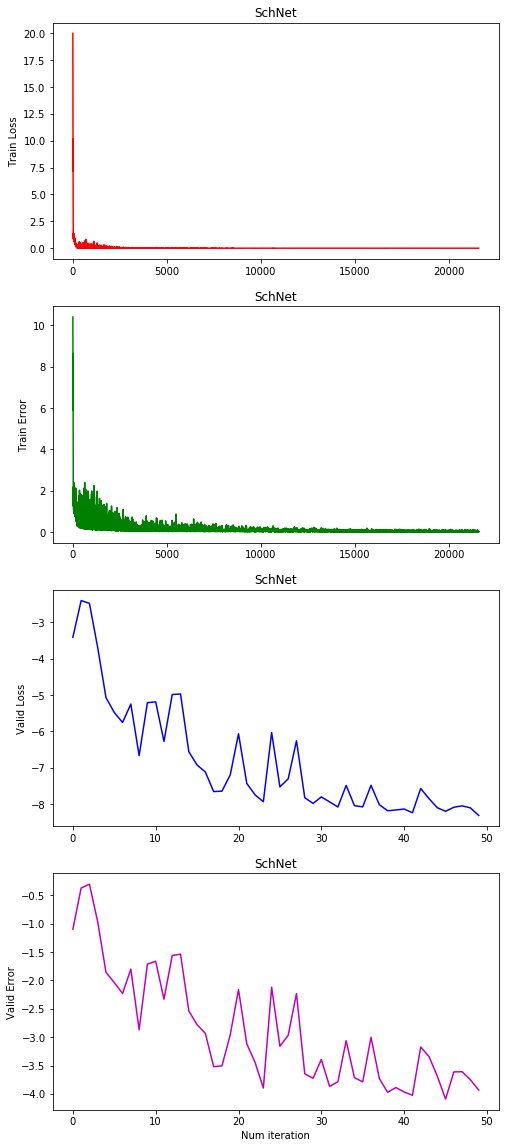

In [ ]:
model = Schnet()

#model = torch.load('/content/gdrive/My Drive/QM9/schnet_model_best_revised.pt')

epochs = 50
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.MSELoss()
evaluation = lambda output, target: torch.mean(torch.abs(output - target) / torch.abs(target))
scheduler = lrs.StepLR(optimizer, 1, 0.95)

model = model.cuda()
criterion = criterion.cuda()

best_er1 = 100

train_losses = []
train_errs = []
valid_losses = []
valid_errs = []



# Epoch for loop
for epoch in range(0, epochs):

    # train for one epoch
    train_loss, train_err = train(train_loader, model, criterion, optimizer, epoch, evaluation)

    train_losses.append(train_loss)
    train_errs.append(train_err)

    # evaluate on test set
    er1, valid_loss = validate(valid_loader, model, criterion, evaluation)

    valid_errs.append(math.log(er1))
    valid_losses.append(math.log(valid_loss))

    scheduler.step()

    if er1 < best_er1:
      best_er1 = er1
      print(best_er1, epoch)
      torch.save(model, '/content/gdrive/My Drive/QM9/schnet_model_best_add.pt')
    


# For testing
test_err, _= validate(test_loader, model, criterion, evaluation)





concat_train_loss = sum(train_losses, [])
concat_train_err = sum(train_errs, [])


plt.figure(figsize=(8, 20))
plt.subplot(4, 1, 1)
plt.plot(concat_train_loss, 'r')
plt.title('SchNet')
plt.ylabel('Train Loss')

plt.subplot(4, 1, 2)
plt.plot(concat_train_err, 'g')
plt.title('SchNet')
plt.ylabel('Train Error')

plt.subplot(4, 1, 3)
plt.plot(valid_losses, 'b')
plt.title('SchNet')
plt.ylabel('Valid Loss')

plt.subplot(4, 1, 4)
plt.plot(valid_errs, 'm')
plt.title('SchNet')
plt.ylabel('Valid Error')
plt.xlabel('Num iteration')

print(test_err)

In [ ]:

class Qm9_test(data.Dataset):

    # Constructor
    def __init__(self, data_list,ids, target_transform=None, e_representation='raw_distance'):
        self.data_list = data_list
        self.ids = ids
        self.target_transform = target_transform
        self.e_representation = e_representation

    def __getitem__(self, index):
        index = 211
        g = self.data_list[self.ids[index]]
        x = g['x']
        r = g['r']
        target = g['y']

        if self.target_transform is not None:
            target = self.target_transform(target)
        return (x, r, target)

    def __len__(self):
        return len(self.ids)

    def set_target_transform(self, target_transform):
        self.target_transform = target_transform

    def get_statics(self):

        targets = []
        for index in range(len(self.ids)):
          targets.append(self.data_list[self.ids[211]]['y'])
        targets = torch.stack(targets)

        return torch.mean(targets, dim=0), torch.std(targets, dim=0)

def collate_g_test(batch):

    batch_sizes = np.max(np.array([x.size(0) for (x, r, target) in batch]))

    x = np.zeros((len(batch), batch_sizes, 13))
    #x = np.zeros((len(batch), batch_sizes, 5))
    r = np.zeros((len(batch), batch_sizes, 3))
    target = np.zeros((len(batch), 1))

    for i in range(len(batch)):

        num_nodes = batch[i][0].size(0)
        x[i, 0:num_nodes, :] = batch[i][0]
        r[i, 0:num_nodes, :] = batch[i][1]

        target[i, :] = batch[i][2]

        r[i, 0, :] = torch.tensor(r[i, 0, :]) + i*0.5e-2*torch.ones(3)

    x = torch.FloatTensor(x)
    r = torch.FloatTensor(r)
    target = torch.FloatTensor(target)
    
    return x, r, target

model = torch.load('/content/gdrive/My Drive/QM9/schnet_model_best_add.pt')


print('Prepare files')

idx = np.random.permutation(133245)
idx = idx.tolist()
dist_test_ids = idx[:1000]


dist_test = Qm9_test(qm9, dist_test_ids)

dist_test_loader = torch.utils.data.DataLoader(dist_test,
                                            batch_size=256, shuffle=True,
                                            collate_fn=collate_g_test,
                                            num_workers=0)

# switch to evaluate mode
model.eval()



Prepare files


Schnet(
  (embedding): Linear(in_features=13, out_features=64, bias=True)
  (interaction): ModuleList(
    (0): Interaction(
      (atom_wise): ModuleList(
        (0): NNet(
          (fcs): ModuleList(
            (0): Linear(in_features=64, out_features=128, bias=True)
            (1): Linear(in_features=128, out_features=64, bias=True)
          )
        )
        (1): NNet(
          (fcs): ModuleList(
            (0): Linear(in_features=64, out_features=128, bias=True)
            (1): Linear(in_features=128, out_features=64, bias=True)
          )
        )
        (2): NNet(
          (fcs): ModuleList(
            (0): Linear(in_features=64, out_features=128, bias=True)
            (1): Linear(in_features=128, out_features=64, bias=True)
          )
        )
      )
      (cfconv): CFConv(
        (dense): ModuleList(
          (0): NNet(
            (fcs): ModuleList(
              (0): Linear(in_features=300, out_features=256, bias=True)
              (1): Linear(in_featur

0


Text(0.5, 0, 'Distance')

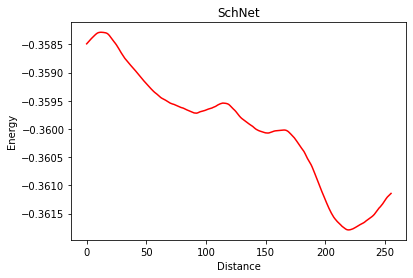

In [ ]:
end = time.time()
outputs = []

for i, (h, e, target) in enumerate(dist_test_loader):

    # Prepare input data
    h, e, target = h.cuda(), e.cuda(), target.cuda()
    #h, e, target = Variable(h), Variable(e), Variable(target)

    # Compute output

    output = model(h, e)


    print(i)
    break

for i in range(len(output)):
  outputs.append(output[i].item())
plt.plot(outputs, 'r')
plt.title('SchNet')
plt.ylabel('Energy')
plt.xlabel('Distance')


In [ ]:
print(test_err)